In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import pandas as pd

# plotting tools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from deepomics import utils, visualize

np.random.seed(33) # for reproducibility

## Get ground truth motifs from JASPAR database

In [2]:
def get_jaspar_motifs(file_path):
    def get_motif(f):
        line = f.readline()
        name = line.strip().split()[1]
        pfm = []
        for i in range(4):
            line = f.readline()
            if len(line.split()[1]) > 1:
                pfm.append(np.asarray(np.hstack([line.split()[1][1:], line.split()[2:-1]]), dtype=float))
            else:
                pfm.append(np.asarray(line.split()[2:-1], dtype=float))
        pfm = np.vstack(pfm)
        sum_pfm = np.sum(pfm, axis=0)
        pwm = pfm/np.outer(np.ones(4), sum_pfm)
        line = f.readline()
        return name, pwm

    num_lines = sum(1 for line in open(file_path))
    num_motifs = int(num_lines/6)

    f = open(file_path)
    tf_names = []
    tf_motifs = []
    for i in range(num_motifs):
        name, pwm = get_motif(f)
        tf_names.append(name)
        tf_motifs.append(pwm)

    return tf_motifs, tf_names

# parse JASPAR motifs
savepath = '../data'
file_path = os.path.join(savepath, 'pfm_vertebrates.txt')
motif_set, motif_names = get_jaspar_motifs(file_path)

# get a subset of core motifs 
core_names = ['Arid3a', 'CEBPB', 'FOSL1', 'Gabpa', 'MAFK', 'MAX', 
              'MEF2A', 'NFYB', 'SP1', 'SRF', 'STAT1', 'YY1']

strand_motifs = []
core_index = []
for name in core_names:
    strand_motifs.append(motif_set[motif_names.index(name)])
    core_index.append(motif_names.index(name))

# generate reverse compliments
core_motifs = []
for pwm in strand_motifs:
    core_motifs.append(pwm)
    reverse = pwm[:,::-1]
    core_motifs.append(reverse[::-1,:]) 


## Print and save ground truth motifs

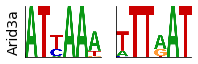

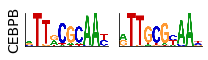

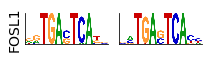

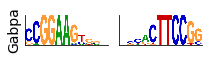

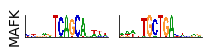

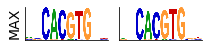

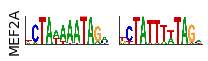

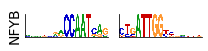

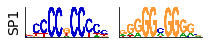

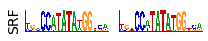

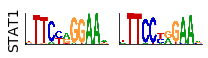

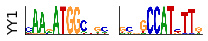

In [3]:
i=0
for j in range(0,len(core_motifs),2):
    
    save_path = utils.make_directory('../results','ground_truth_motifs')
    fig = plt.figure(figsize = (3,1))
    plt.subplot(1,2,1)
    logo = visualize.seq_logo(core_motifs[j], height=100, nt_width=50, norm=0, alphabet='dna')
    visualize.plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(core_names[i], fontsize=14)

    plt.subplot(1,2,2)
    logo = visualize.seq_logo(core_motifs[j+1], height=100, nt_width=50, norm=0, alphabet='dna')
    visualize.plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.xticks([])
    plt.yticks([])

    fig.savefig(os.path.join(save_path, core_names[i]+'.pdf'), format='pdf', dpi=200, bbox_inches='tight')
    
    i += 1

## Useful functions to generate dataset

In [4]:
def generate_model(core_motifs, seq_length):
    
    num_motif = len(core_motifs)
    cum_dist = np.cumsum([0, 0.5, 0.25, 0.17, 0.05, 0.3])
    
    # sample core motifs for each grammar
    valid_sim = False
    while not valid_sim:

        # determine number of core motifs in a given grammar model
        num_interactions = np.where(np.random.rand() > cum_dist)[0][-1]+1 #np.random.randint(min_interactions, max_interactions)

        # randomly sample motifs
        sim_motifs = np.random.randint(num_motif, size=num_interactions)
        num_sim_motifs = len(sim_motifs)
        #sim_motifs = sim_motifs[np.random.permutation(num_sim_motifs)]
        
        # verify that distances aresmaller than sequence length
        distance = 0
        for i in range(num_sim_motifs):
            distance += core_motifs[sim_motifs[i]].shape[1]
        if seq_length > distance > 0:
            valid_sim = True    

    # simulate distances between motifs + start 
    valid_dist = False
    while not valid_dist:
        remainder = seq_length - distance
        sep = np.random.uniform(0, 1, size=num_sim_motifs+1)
        sep = np.round(sep/sum(sep)*remainder).astype(int)
        if np.sum(sep) == remainder:
            valid_dist = True

    # build a PWM for each regulatory grammar
    pwm = np.ones((4,sep[0]))/4
    for i in range(num_sim_motifs):
        pwm = np.hstack([pwm, core_motifs[sim_motifs[i]], np.ones((4,sep[i+1]))/4])

    return pwm, sim_motifs


def simulate_sequence(sequence_pwm):
    """simulate a sequence given a sequence model"""

    nucleotide = 'ACGT'

    # sequence length
    seq_length = sequence_pwm.shape[1]

    # generate uniform random number for each nucleotide in sequence
    Z = np.random.uniform(0,1,seq_length)

    # calculate cumulative sum of the probabilities
    cum_prob = sequence_pwm.cumsum(axis=0)

    # go through sequence and find bin where random number falls in cumulative 
    # probabilities for each nucleotide
    one_hot_seq = np.zeros((4, seq_length))
    for i in range(seq_length):
        index=[j for j in range(4) if Z[i] < cum_prob[j,i]][0]
        one_hot_seq[index,i] = 1
    return one_hot_seq


def get_label(labels, max_labels):
    unique_labels = np.unique(np.floor(labels/2).astype(int))
    
    targets = np.zeros((1, max_labels))
    
    for i in unique_labels:
        targets[0, i] = 1
    
    return targets


## Sequence logo of example synthetic sequence models

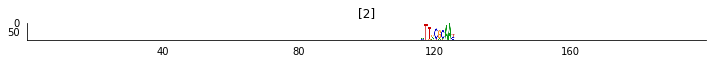

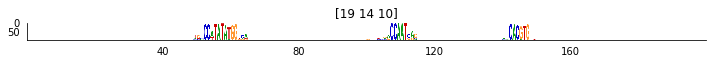

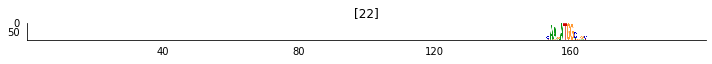

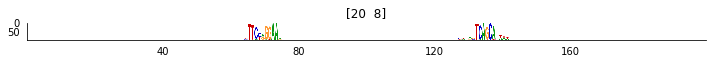

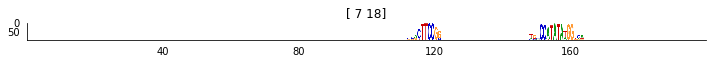

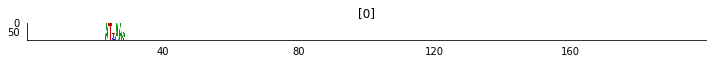

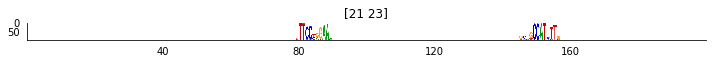

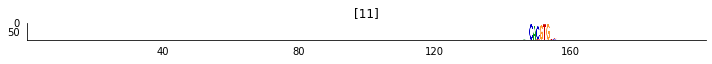

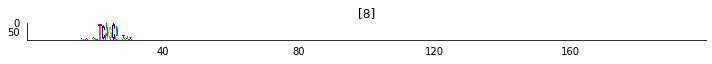

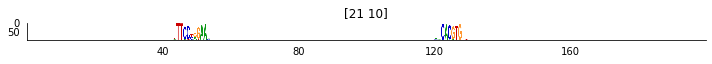

In [5]:
seq_length = 200           # length of sequence
min_interactions = 1       # exponential rate of number of motifs for each grammar
max_interactions = 5
num_plot = 10              # number of regulatory grammars
max_labels = len(core_names)
#[50, 25, 17, 5, 3]

# sample the motifs and distance between each motif for each grammar
seq_model = []
targets = []
for j in range(num_plot):    
    pwm, labels = generate_model(core_motifs, seq_length)
    targets.append(get_label(labels, max_labels))
    
    logo = visualize.seq_logo(pwm, height=50, nt_width=20, norm=0, alphabet='dna')
    fig = plt.figure(figsize=(10,2))
    visualize.plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.title(str(labels))
    #plt.title('model ' + str(i), fontsize=10)


## Simulate synthetic sequences

In [6]:
# dataset parameters
num_seq = 25000             # number of sequences
seq_length = 200            # lsaength of sequence
min_interactions = 1        # exponential rate of number of motifs for each grammar
max_interactions = 5
max_labels = len(core_names)

# generate sythetic sequences as a one-hot representation
seq_pwm = []
seq_model = []    
targets = []
for j in range(num_seq):
    signal_pwm, labels = generate_model(core_motifs, seq_length)
    seq_pwm.append(simulate_sequence(signal_pwm))
    targets.append(get_label(labels, max_labels))
    seq_model.append(signal_pwm)
    
targets = np.vstack(targets)

## Split dataset into train, validation, and test sets and Save

In [7]:
def split_data(data, label, model, split_size):
    """split data into train set, cross-validation set, and test set"""
    
    def subset_data(data, label, model, sub_index):
        """returns a subset of the data and labels based on sub_index"""
        
        num_sub = len(sub_index)
        sub_set_label = []
        sub_set_seq = []
        sub_set_model = []
        for index in sub_index:
            sub_set_seq.append([data[index]])
            sub_set_label.append(label[index])
            sub_set_model.append([model[index]])
        sub_set_seq = np.vstack(sub_set_seq)
        sub_set_label = np.vstack(sub_set_label)
        sub_set_model = np.vstack(sub_set_model)
    
        return (sub_set_seq, sub_set_label, sub_set_model)

    
    # determine indices of each dataset
    N = len(data)
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],N)).astype(int) 

    # shuffle data
    shuffle = np.random.permutation(N)

    # training dataset
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    cross_validation_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    print('Generating training data')
    train = subset_data(data, label, model, train_index)

    print('Generating cross-validation data')
    cross_validation = subset_data(data, label, model, cross_validation_index)
    
    print('Generating test data')    
    test = subset_data(data, label, model, test_index)
    
    return train, cross_validation, test


def save_dataset(savepath, train, valid, test):
    f = h5py.File(savepath, "w")
    dset = f.create_dataset("X_train", data=train[0], compression="gzip")
    dset = f.create_dataset("Y_train", data=train[1], compression="gzip")
    dset = f.create_dataset("model_train", data=train[2], compression="gzip")
    dset = f.create_dataset("X_valid", data=valid[0], compression="gzip")
    dset = f.create_dataset("Y_valid", data=valid[1], compression="gzip")
    dset = f.create_dataset("model_valid", data=valid[2], compression="gzip")
    dset = f.create_dataset("X_test", data=test[0], compression="gzip")
    dset = f.create_dataset("Y_test", data=test[1], compression="gzip")
    dset = f.create_dataset("model_test", data=test[2], compression="gzip")
    f.close()
    
    
# split into training, cross-validation, and test sets
print("Splitting dataset into train, cross-validation, and test")
train_size = 0.7
cross_validation_size = 0.1
test_size = 0.20
split_size = [train_size, cross_validation_size, test_size]
train, valid, test = split_data(seq_pwm, targets, seq_model, split_size)

# save to file
filename =  'synthetic_dataset.h5' 
file_path = os.path.join(savepath, filename)
print('Saving to: ' + file_path)
save_dataset(file_path, train, valid, test)

Splitting dataset into train, cross-validation, and test
Generating training data
Generating cross-validation data
Generating test data
Saving to: ../data/synthetic_dataset.h5
